In [2]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import fiona

import time
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import rtree

In [3]:
from shapely.geometry import Point, Polygon, MultiLineString
from shapely.ops import unary_union

In [1]:
import rasterio as rio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import mapping
from rasterio.transform import Affine

In [4]:
shape_file_path = 'post_processing/remaymonthlyreportformassxwalkproject/Image_Index_2021/COQ2021INDEX_POLY.shp'
tile_gdb = 'post_processing/18TXM990635/Crosswalk_18TXM990635.gdb/'
results_gdb = 'post_processing/Combined_Results_2021.gdb/'
roads_gdb = 'post_processing/MassDOT_Roads_GDB/MassDOT_Roads_GDB/MassDOT_Roads.gdb/'

In [5]:
for i in fiona.listlayers(results_gdb):
    print(i)

Res_UTM_18
Res_UTM_19


In [6]:
for i in fiona.listlayers(roads_gdb):
    print(i)

EOTMAJROADS_ARC
EOTMAJROADS_RTE_MAJOR
EOTROADS_ARC


In [7]:
tile_path = os.path.join(tile_gdb)
results_path = os.path.join(results_gdb)
roads_path = os.path.join(roads_gdb)

### 2021 Shape file

In [8]:
shape_file = gpd.read_file(shape_file_path)

### Load results (Western Mass)

In [9]:
start = time.time()
western_mass = gpd.read_file(results_path, driver='FileGDB', layer=0)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:00:07.431537


### Load results (Eastern Mass)

In [10]:
start = time.time()
eastern_mass = gpd.read_file(results_path, driver='FileGDB', layer=1)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:00:27.037691


### Combined results

In [11]:
# Check if the CRS are different and if transformation is needed
if western_mass.crs != eastern_mass.crs:
    # Transform lyr2 to have the same CRS as lyr1
    eastern_mass_transformed = eastern_mass.to_crs(western_mass.crs)
else:
    eastern_mass_transformed = eastern_mass.crs
combined_results = gpd.GeoDataFrame(pd.concat([western_mass, eastern_mass_transformed], ignore_index=True), crs=western_mass.crs)

### Calculate statistics

In [12]:
quantiles = combined_results['Shape_Area'].quantile([0.25, 0.5, 0.75])
median_val = quantiles[0.5]
print("Quantiles: ")
quantiles

Quantiles: 


0.25     1.052525
0.50    20.152160
0.75    40.760909
Name: Shape_Area, dtype: float64

### Load road network

In [13]:
start = time.time()
roads = gpd.read_file(roads_path, driver='FileGDB', layer=2)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:08:51.593781


In [382]:
def get_polygon_intersections(crosswalks, roads, buffering_parameter=1):
    '''Return all detected polygons of a specified size which intersect with the road network.'''
    potential_intersections = []
    intersection_info = []
    # Create a dictionary to store unique IDs and their associated data
    unique_data = {}
    # Create an R-tree index (results)
    idx = rtree.index.Index()
    
    # Calculate statistics
    quantiles = crosswalks['Shape_Area'].quantile([0.25, 0.5, 0.75])
    print("Quantiles:")
    print(quantiles)
    
    # Ensure the two dataset share a coordinate reference system (crs)
    if crosswalks.crs != roads.crs:
        roads_transformed = roads.to_crs(crosswalks.crs)
    else:
        roads_transformed = roads.crs
    
    # Populate the R-tree with the bounding boxes of the road segments
    for i, road_segment in enumerate(roads_transformed['geometry']):
        minx, miny, maxx, maxy = road_segment.bounds
        idx.insert(i, (minx, miny, maxx, maxy))
        
    # Query the R-tree for potential intersections
    for i in range(len(crosswalks)):
        polygon = crosswalks.iloc[i]['geometry']
        # Expand the original polygon by a specified distance in the same units as the crs
        buffered_polygon = polygon.buffer(buffering_parameter) # Adjust buffering parameter (proximity analysis / safety zone)
        bounding_box = buffered_polygon.bounds
        # Bounding box coordinates 
        minx, miny, maxx, maxy = bounding_box
        # Create a Polygon from the bounding box coordinates
        bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
        potential_intersections.append(list(idx.intersection(bounding_polygon.bounds)))
    
    # Iterate through potential intersections and check for actual intersections
    for i, segment_list in enumerate(potential_intersections):
        object_id = i + 1
        polygon = western_mass['geometry'][i]
        buffered_polygon = polygon.buffer(buffering_parameter)
        bounding_box = buffered_polygon.bounds
        # Bounding box coordinates
        minx, miny, maxx, maxy = bounding_box
        # Create a Polygon from the bounding box coordinates
        bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])

        # Create lists to store all road segments that intersect with the polygon and the intersections
        road_segments = []    
        intersected_segments = []

        for segment_id in segment_list:
            road_segment = roads_transformed['geometry'][segment_id]             
            # Specify polygon area threshold (currently, 75th percentile)
            if buffered_polygon.intersects(road_segment) and polygon.area >= quantiles[0.75]:
                road_segments.append(road_segment)
                intersected_segments.append(bounding_polygon.intersection(road_segment))
                # Append the polygon and its intersected segments to the intersection_info list
                intersection_info.append((object_id, polygon, buffered_polygon, bounding_polygon, road_segments, intersected_segments))    

    # Iterate through the list and add unique data to the dictionary
    for item in intersection_info:
        unique_id = item[0]
        if unique_id not in unique_data:
            unique_data[unique_id] = item

    # Convert the dictionary values back to a list to get unique items
    unique_data_list = list(unique_data.values())
    
    return(unique_data_list)

In [383]:
start = time.time()
results = get_polygon_intersections(western_mass, roads)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

Quantiles:
0.25     0.277368
0.50     3.870911
0.75    29.994463
Name: Shape_Area, dtype: float64
0:01:10.462484


In [384]:
len(results)

7607

In [385]:
def convert_results_to_gdf(results):
    '''Convert polygon intersection results to a GeoDataFrame.'''
    if isinstance(results, gpd.GeoDataFrame):
        geo_df = results
    else:
        # Initialize empty lists to store GeoDataFrame columns
        ids = []
        polygons = []
        buffered_polygons = []
        bounding_polygons = []
        multilinestrings = []
        intersections = []

        # Extract data from each entry in results
        for entry in results:
            object_id, polygon, buffered_polygon, bounding_polygon, multilines, lines = entry

            # Append data to the lists
            ids.append(object_id)
            polygons.append(polygon)
            buffered_polygons.append(buffered_polygon)
            bounding_polygons.append(bounding_polygon)
            multilinestrings.append(multilines)
            intersections.append(lines)

        # Create a dictionary with field names as keys and lists as values
        data = {
            'object_id': ids,
            'polygon': polygons,
            'buffered_polygon': buffered_polygons,
            'bounding_polygon': bounding_polygons,
            'road_segments': multilinestrings,
            'intersections': intersections,
        }

        # Create the GeoDataFrame
        geo_df = gpd.GeoDataFrame(data, geometry='polygon')

    return(geo_df)

In [386]:
res_gdf = convert_results_to_gdf(results)

In [387]:
res_gdf.iloc[5][5]

[<LINESTRING (720726.877 4718959.583, 720740.302 4718954.143)>,
 <LINESTRING (720740.302 4718954.143, 720741.152 4718965.379)>]

In [388]:
def map_polygon_to_tile(gdf, shape_file):
    '''Determine the tile each detected polygon belongs to using the index approach.'''
    # Create a dictionary to store the mapping of polygons to tiles
    gdf_results = gdf.copy()
    polygon_to_tile = {}

    # Create spatial indices for both geo_df and shape_file
    gdf_sindex = gdf_results.sindex
    shape_file_sindex = shape_file.sindex

    # Iterate through the polygons in geo_df
    for geo_index, geo_row in gdf_results.iterrows():
        geo_bounds = geo_row['polygon'].bounds

        # Iterate through the tiles in the shape_file
        for tile_index in shape_file_sindex.intersection(geo_bounds):
            tile_geometry = shape_file.at[tile_index, 'geometry']

            # Check if the bounding box of the polygon intersects with the tile
            if geo_row['polygon'].intersects(tile_geometry):
                polygon_to_tile[geo_index] = shape_file.at[tile_index, 'TILENAME']
                break  # Stop checking further tiles once a match is found

    # Create a new column in geo_df to store the corresponding tile name
    gdf_results['TILENAME'] = gdf_results.index.map(polygon_to_tile)
    return(gdf_results)

In [389]:
polygon_mappings = map_polygon_to_tile(res_gdf, shape_file_transformed)

In [263]:
results[5][4]

[<LINESTRING (720726.877 4718959.583, 720740.302 4718954.143)>,
 <LINESTRING (720740.104 4718949.35, 720740.302 4718954.143)>,
 <LINESTRING (720740.302 4718954.143, 720741.152 4718965.379)>]

In [356]:
res_gdf.iloc[5][4]

[<LINESTRING (720726.877 4718959.583, 720740.302 4718954.143)>,
 <LINESTRING (720740.302 4718954.143, 720741.152 4718965.379)>]

In [275]:
example = polygon_mappings.iloc[5][4]
# Create a DataFrame with the LINESTRINGs
data = {'geometry': example}
df = gpd.GeoDataFrame(data, geometry='geometry')

<AxesSubplot:>

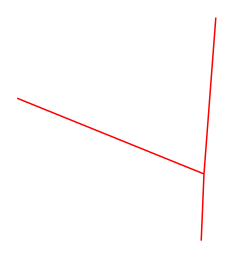

In [276]:
# Visualize the itnersection
fig, ax = plt.subplots()
plt.tight_layout()
ax.axis('off')
df.plot(ax=ax, color='red')

In [375]:
res_gdf.iloc[5]

object_id                                                          123
polygon              MULTIPOLYGON (((720732.3000000007 4718950.3500...
bufferred_polygon    POLYGON ((720733.2178013956 4718949.952960209,...
bounding_polygon     POLYGON ((720726.8770885507 4718949.35048952, ...
road_segments        [MULTILINESTRING ((720672.1212349564 4718986.6...
intersections        [LINESTRING (720726.8770885507 4718959.5833026...
Name: 5, dtype: object

In [390]:
def visualize_intersection(crosswalk_intersections, idx, zoom_in=True, save_fig=False):
    '''Sketch out a polygon intersection without an aerial overlay.'''
    if isinstance(crosswalk_intersections, list):
        observation = crosswalk_intersections[idx]
    else:
        observation = crosswalk_intersections.iloc[idx]
    # Convert objects to geodataframes (gdfs)
    polygon_gdf = gpd.GeoDataFrame(geometry=[observation[1]])
    buffered_polygon_gdf = gpd.GeoDataFrame(geometry=[observation[2]])
    bounding_polygon_gdf = gpd.GeoDataFrame(geometry=[observation[3]])
    road_segment_gdf = gpd.GeoDataFrame({'geometry': observation[4]}, geometry='geometry')
    intersection_gdf = gpd.GeoDataFrame({'geometry': observation[5]}, geometry='geometry')
    polygon_area = polygon_gdf.area[0]
    # Visualize the itnersection
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.axis('off')
    polygon_gdf.plot(ax=ax, color='red')
    buffered_polygon_gdf.boundary.plot(ax=ax, linewidth=1, color='blue')
    bounding_polygon_gdf.boundary.plot(ax=ax, linewidth=1, color='orange')
    if(zoom_in):
        intersection_gdf.plot(ax=ax, color='green')
    else:
        road_segment_gdf.plot(ax=ax, color='green')
    plt.title(f'Polygon area: {polygon_area:.2f}')
    if save_fig:
        # Specify the directory path
        save_dir = "post_processing/simple_polygon_intersections/"
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Specify the figure title and file path
        fig_title = os.path.join(save_dir, f"intersection-{idx}.jpg")
        
        # Save the figure
        plt.savefig(fig_title, dpi=300)
    plt.show() 

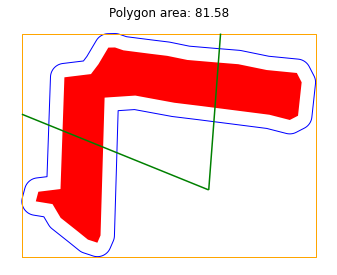

In [391]:
visualize_intersection(res_gdf, 5)

In [287]:
polygon_mappings[polygon_mappings['polygon_id']==res_gdf.iloc[1][0]]['TILENAME']

1    18TYN170295
Name: TILENAME, dtype: object

In [296]:
my_polygon = res_gdf.iloc[5][1]

In [297]:
buffer_dist = 0.01
contour_polygon = my_polygon.buffer(buffer_dist)

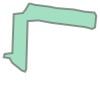

In [302]:
my_polygon

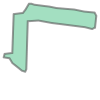

In [298]:
contour_polygon

In [359]:
res_gdf.iloc[5][4]

[<LINESTRING (720726.877 4718959.583, 720740.302 4718954.143)>,
 <LINESTRING (720740.302 4718954.143, 720741.152 4718965.379)>]

In [318]:
bounding_box = contour_polygon.bounds
# Bounding box coordinates 
minx, miny, maxx, maxy = bounding_box
# Create a Polygon from the bounding box coordinates
bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])

In [325]:
print(bounding_box)

(720726.3774004036, 4718948.850734277, 720748.4777915705, 4718965.879134891)


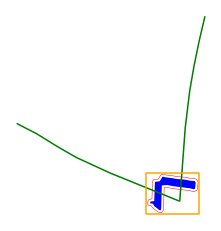

In [360]:
my_polygon = res_gdf.iloc[5][1]
buffer_dist = 1
contour_polygon = my_polygon.buffer(buffer_dist)

fig, ax = plt.subplots()
my_polygon_gdf = gpd.GeoDataFrame(geometry=[my_polygon])
contour_polygon_gdf = gpd.GeoDataFrame(geometry=[contour_polygon])
bounding_polygon_gdf = gpd.GeoDataFrame(geometry=[bounding_polygon])
intersection_segment_gdf = gpd.GeoDataFrame({'geometry': res_gdf.iloc[5][3]}, geometry='geometry')
ax.axis('off')
my_polygon_gdf.plot(ax=ax, color='blue')
contour_polygon_gdf.boundary.plot(ax=ax, linewidth=0.5, color='red')
intersection_segment_gdf.plot(ax=ax, color='green')
bounding_polygon_gdf.boundary.plot(ax=ax, color='orange')
plt.show()

In [330]:
bounding_polygon_gdf.bounds

,minx,miny,maxx,maxy
0,720726.877089,4.718949e+06,720747.977821,4.718965e+06


In [332]:
contour_polygon_gdf.bounds

,minx,miny,maxx,maxy
0,720726.877089,4.718949e+06,720747.977821,4.718965e+06


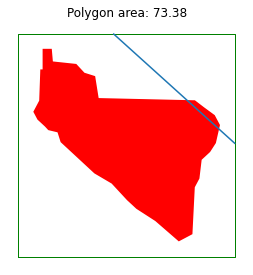

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200145.jp2


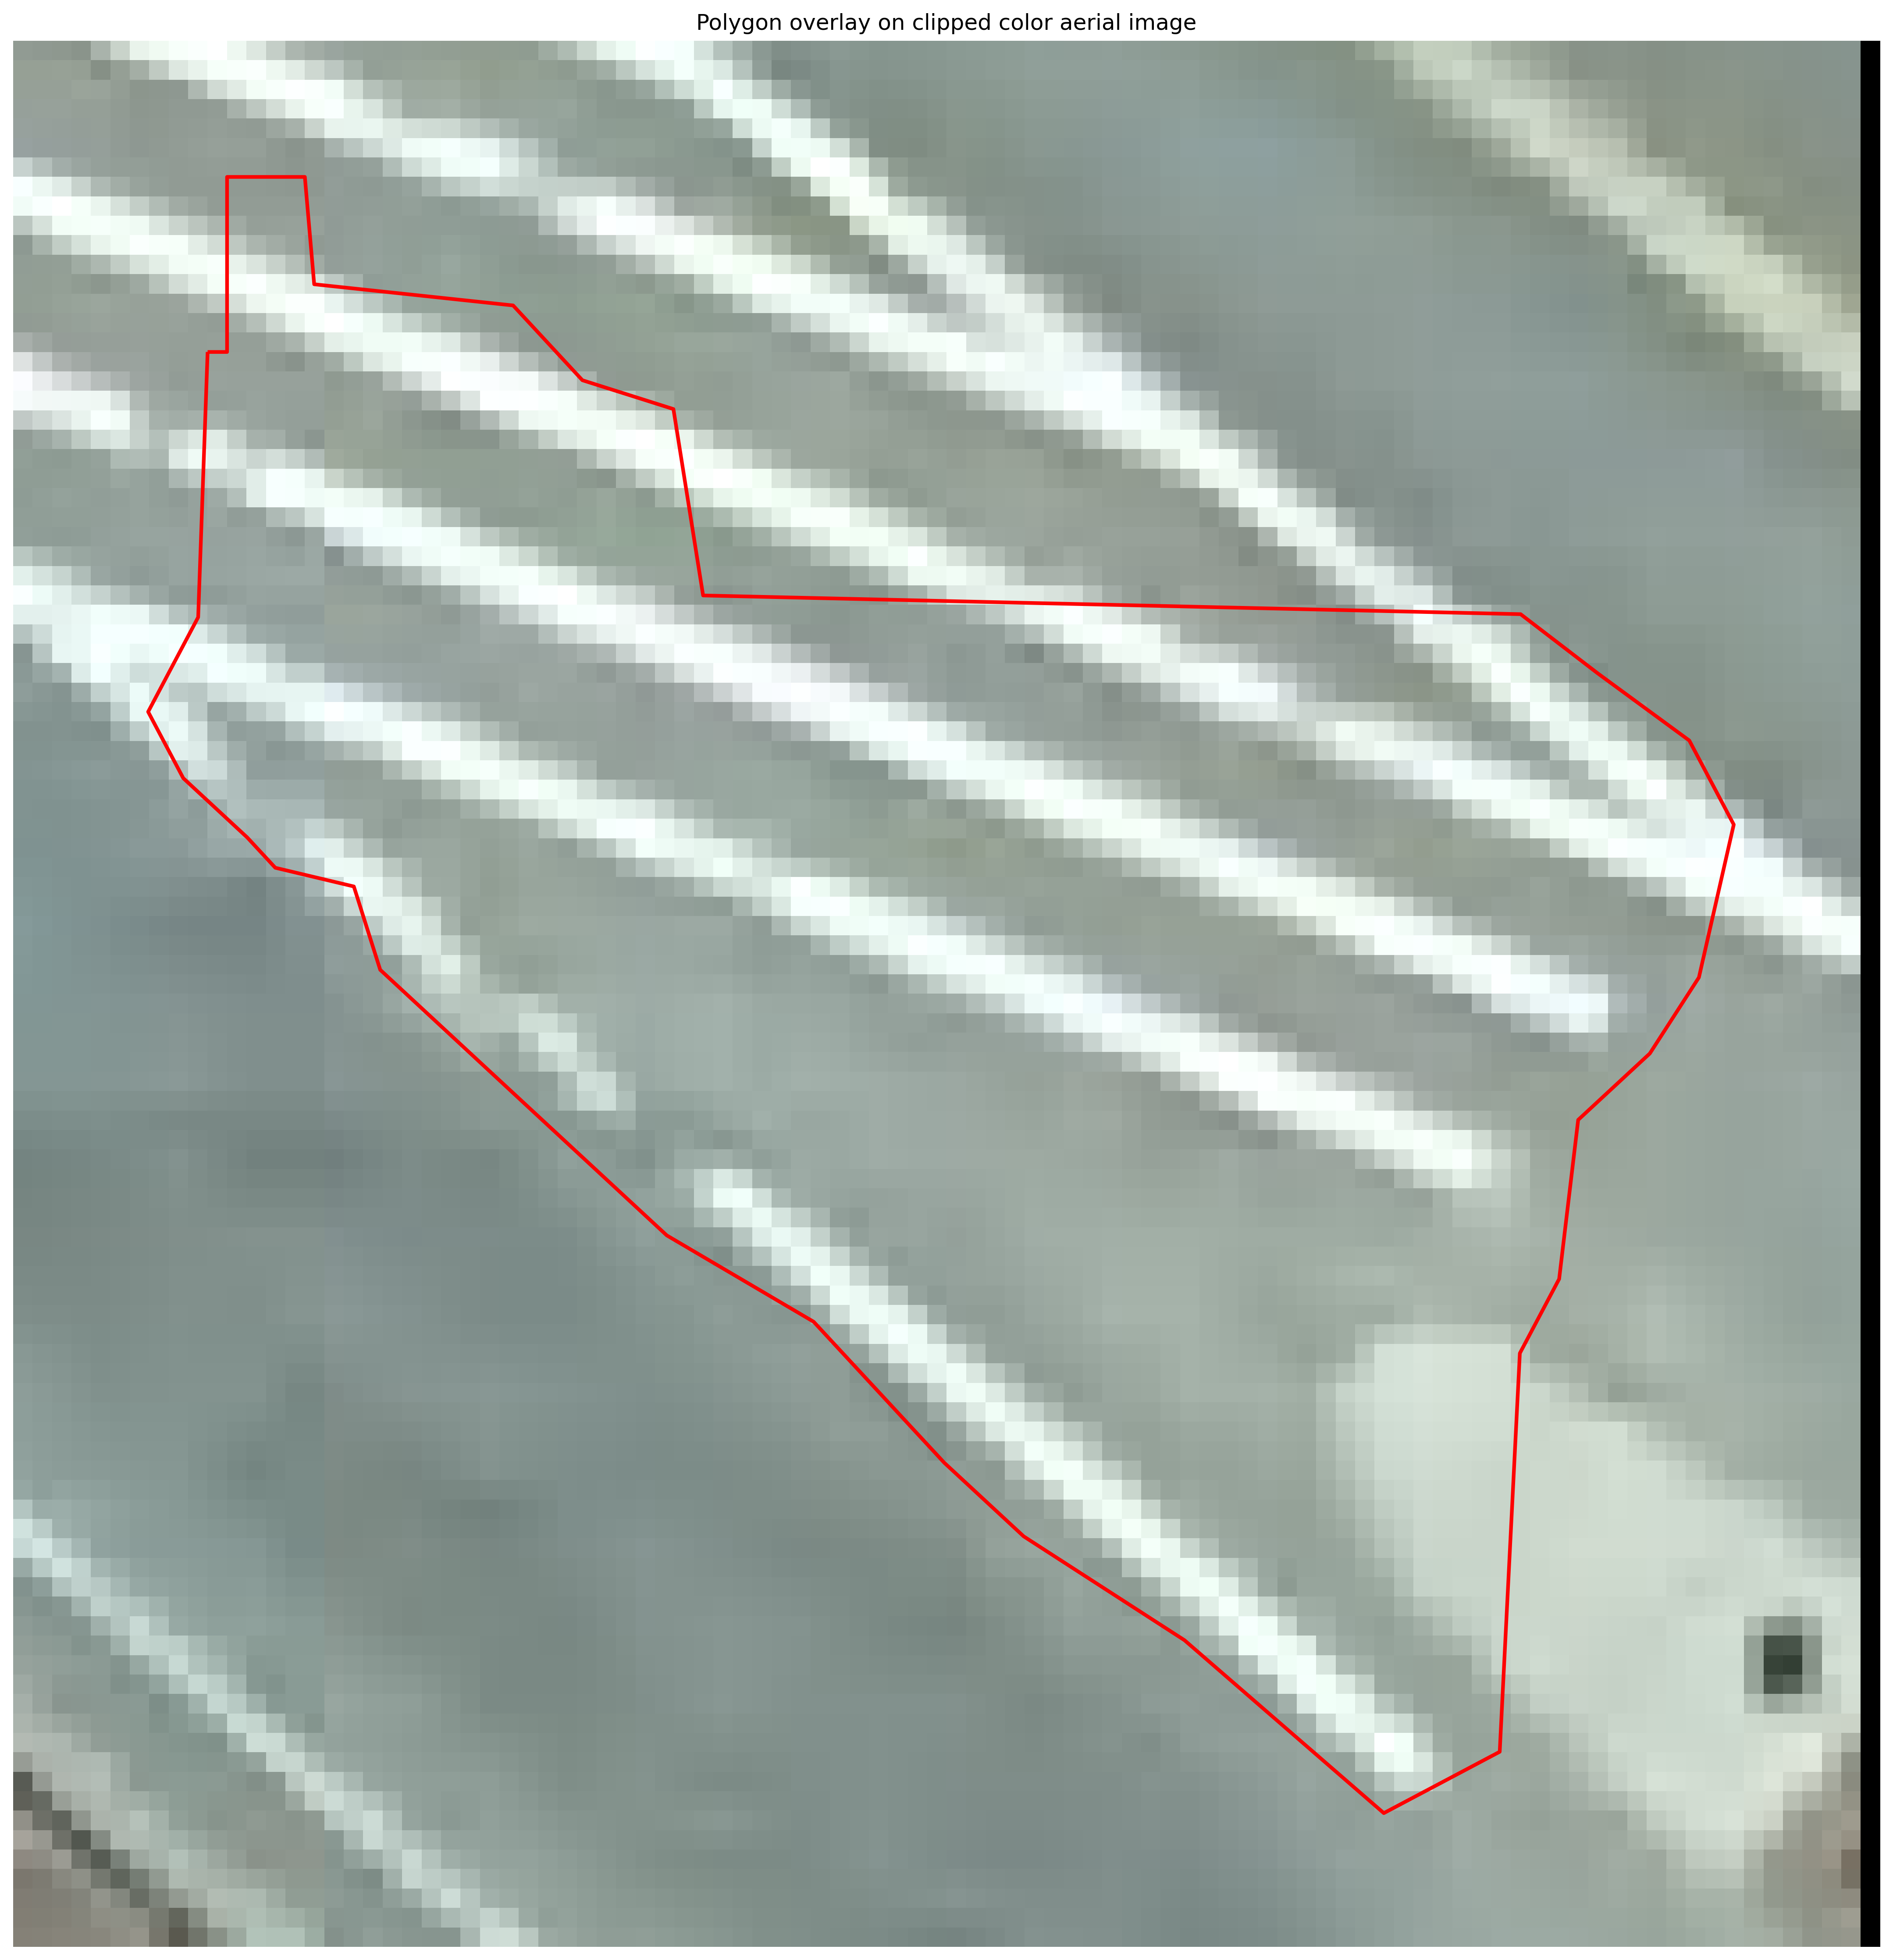

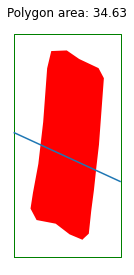

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2


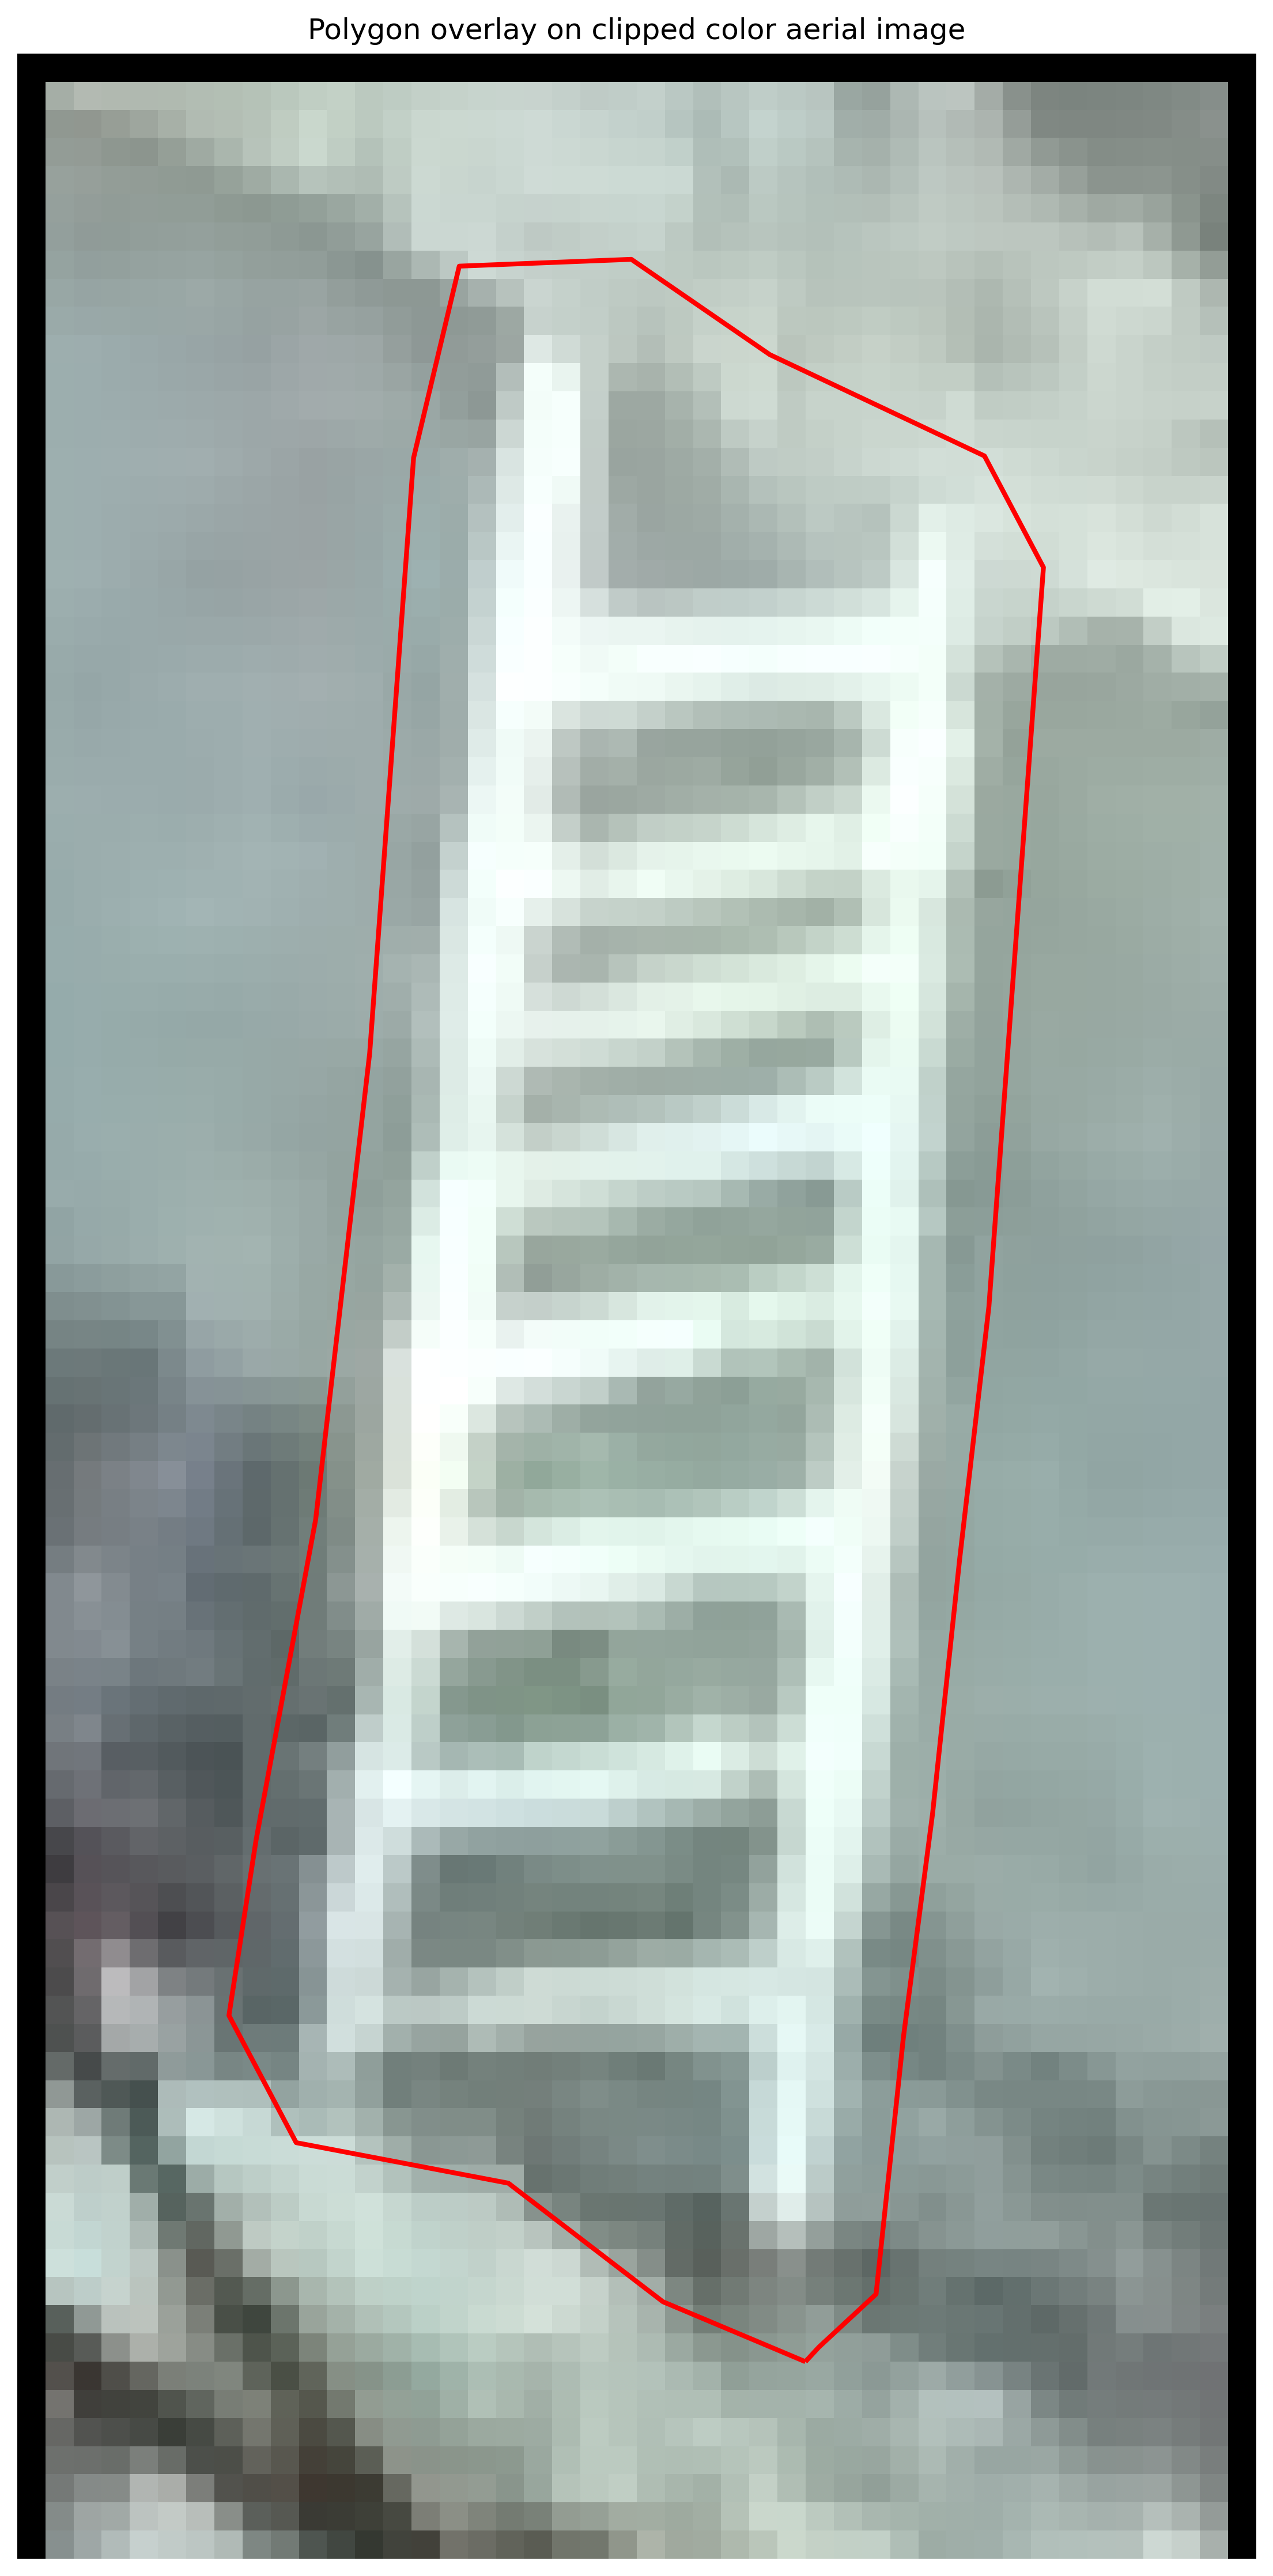

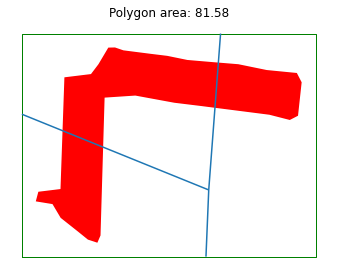

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2


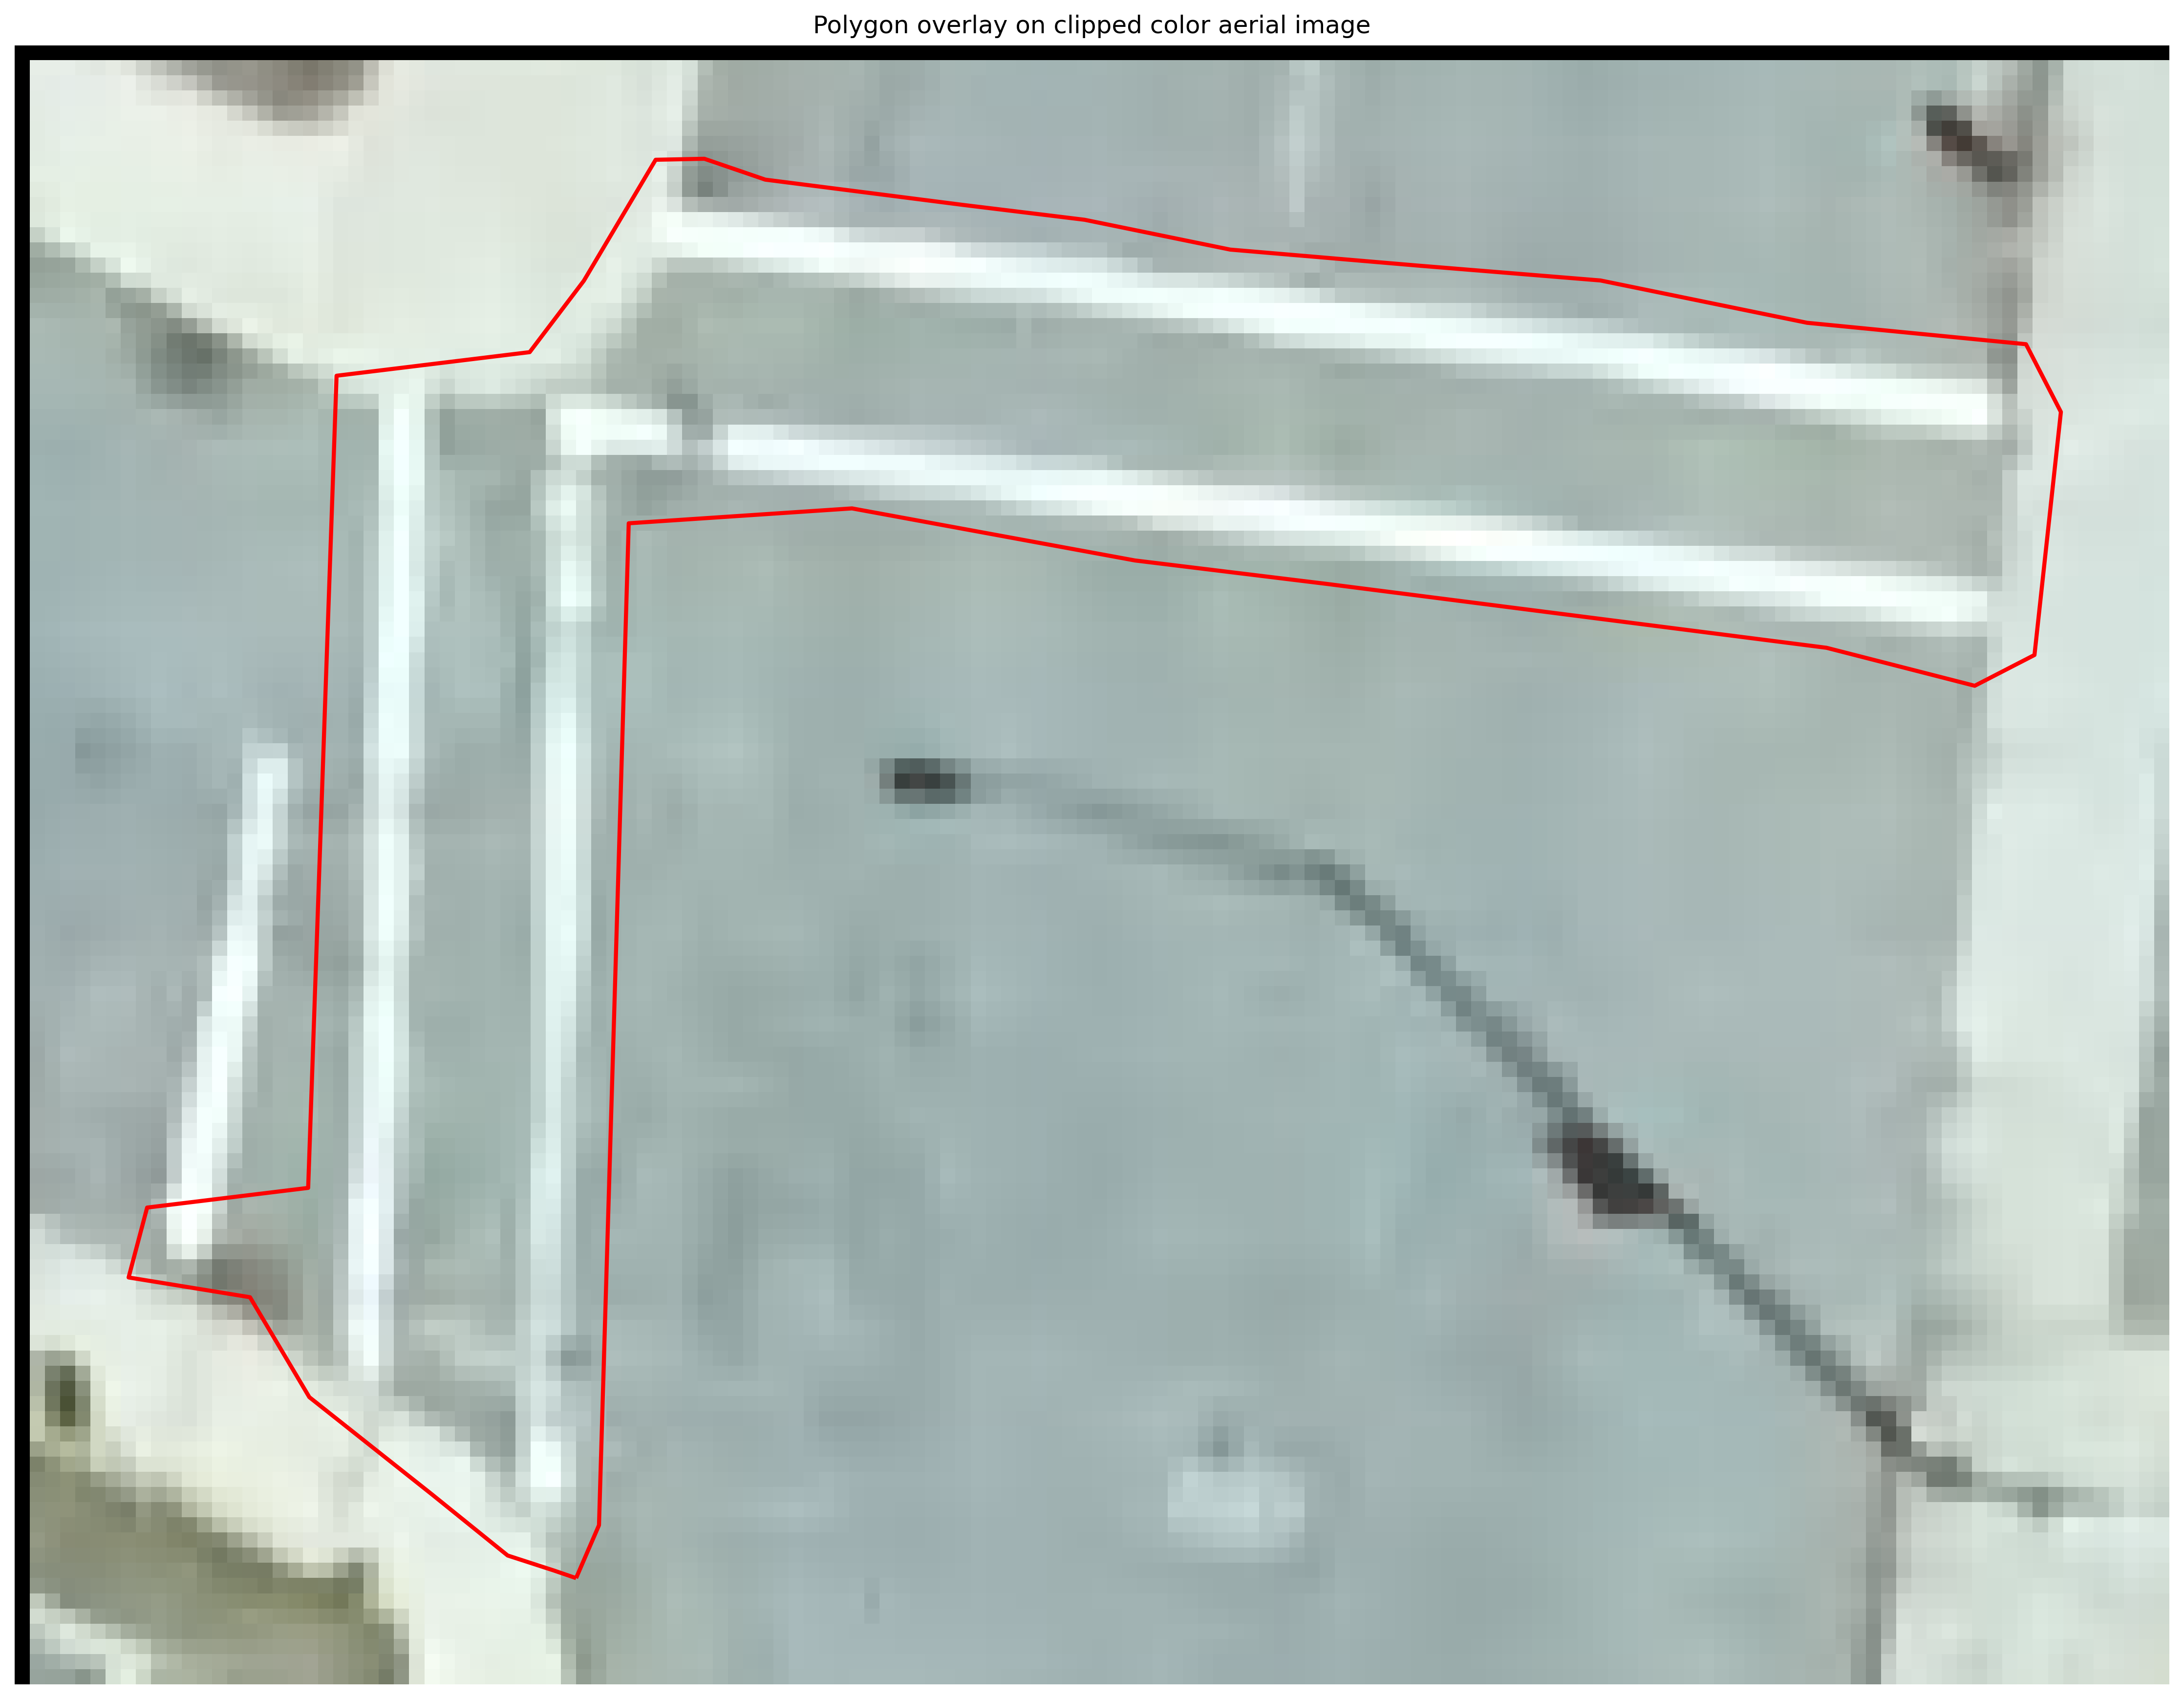

In [289]:
for i in range(3, 6):
    visualize_intersection(res_gdf, i)
    superimpose_polygon_on_tile(polygon_mappings, i)

In [69]:
if western_mass.crs != shape_file.crs:
    shape_file_transformed = shape_file.to_crs(western_mass.crs)
else:
    shape_file_transformed = shape_file.crs

In [70]:
start = time.time()
polygon_mappings = map_polygon_to_tile(res_gdf, shape_file_transformed)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:00:02.192919


In [291]:
len(polygon_mappings)

7771

In [72]:
def superimpose_polygon_on_tile(mappings, idx, grayscale=False, savefig=False):
    tilename = mappings.iloc[idx]['TILENAME']
    bounding_polygon = mappings.iloc[idx]['bounding_polygon']
    polygon = mappings.iloc[idx]['polygon']
    aerial_img_path = 'D:\mass_xwalk\COQ2021INDEX/unzipped/' + tilename + '.jp2'
    aerial_img_path = aerial_img_path.replace('\\', '/')
    print(aerial_img_path)
    
    bounding_polygon_gdf = gpd.GeoDataFrame({'geometry': [bounding_polygon]})
    
    # Open the aerial image with rasterio
    with rio.open(aerial_img_path) as src:
        # Read the three bands representing RGB channels
        red_channel = src.read(1)
        green_channel = src.read(2)
        blue_channel = src.read(3)
        # Clip each color channel to the polygon extent
        clipped_red_channel, transform = rasterio.mask.mask(src, bounding_polygon_gdf.geometry.apply(mapping), crop=True, indexes=1)
        clipped_green_channel, _ = rasterio.mask.mask(src, bounding_polygon_gdf.geometry.apply(mapping), crop=True, indexes=2)
        clipped_blue_channel, _ = rasterio.mask.mask(src, bounding_polygon_gdf.geometry.apply(mapping), crop=True, indexes=3)
        # Stack the clipped color channels to create a composite RGB image
        clipped_image = np.stack((clipped_red_channel, clipped_green_channel, clipped_blue_channel), axis=0)        

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(15, 15), dpi=300)

        # Create a GeoSeries containing the MULTIPOLYGON
        gdf_polygon_series = gpd.GeoSeries(polygon)

        # Plot the polygon on the same axis
        gdf_polygon_series.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, antialiased=True)

        # Plot the clipped JP2 image on the same axis
        extent = bounding_polygon.bounds#(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

        # Configure the plot
        if(grayscale):
            plot_title = 'Polygon overlay on clipped grayscale aerial image'
            show(clipped_image[0], cmap='gray', extent=(extent[0], extent[2], extent[1], extent[3]), ax=ax, alpha=1.0, transform=transform)  # Set alpha to 1.0 to avoid transparency
        else:
            plot_title = 'Polygon overlay on clipped color aerial image'
            show(clipped_image, transform=transform, extent=(extent[0], extent[2], extent[1], extent[3]), ax=ax, alpha=1.0)  # Set alpha to 1.0 to avoid transparency
        ax.set_title(plot_title)
        ax.axis('off')
        plt.tight_layout()

        if(savefig):
            plt.savefig('clipped_jp2_overlay.png', dpi=300, format='png', bbox_inches='tight')

        # Show the plot
        plt.show()

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200145.jp2


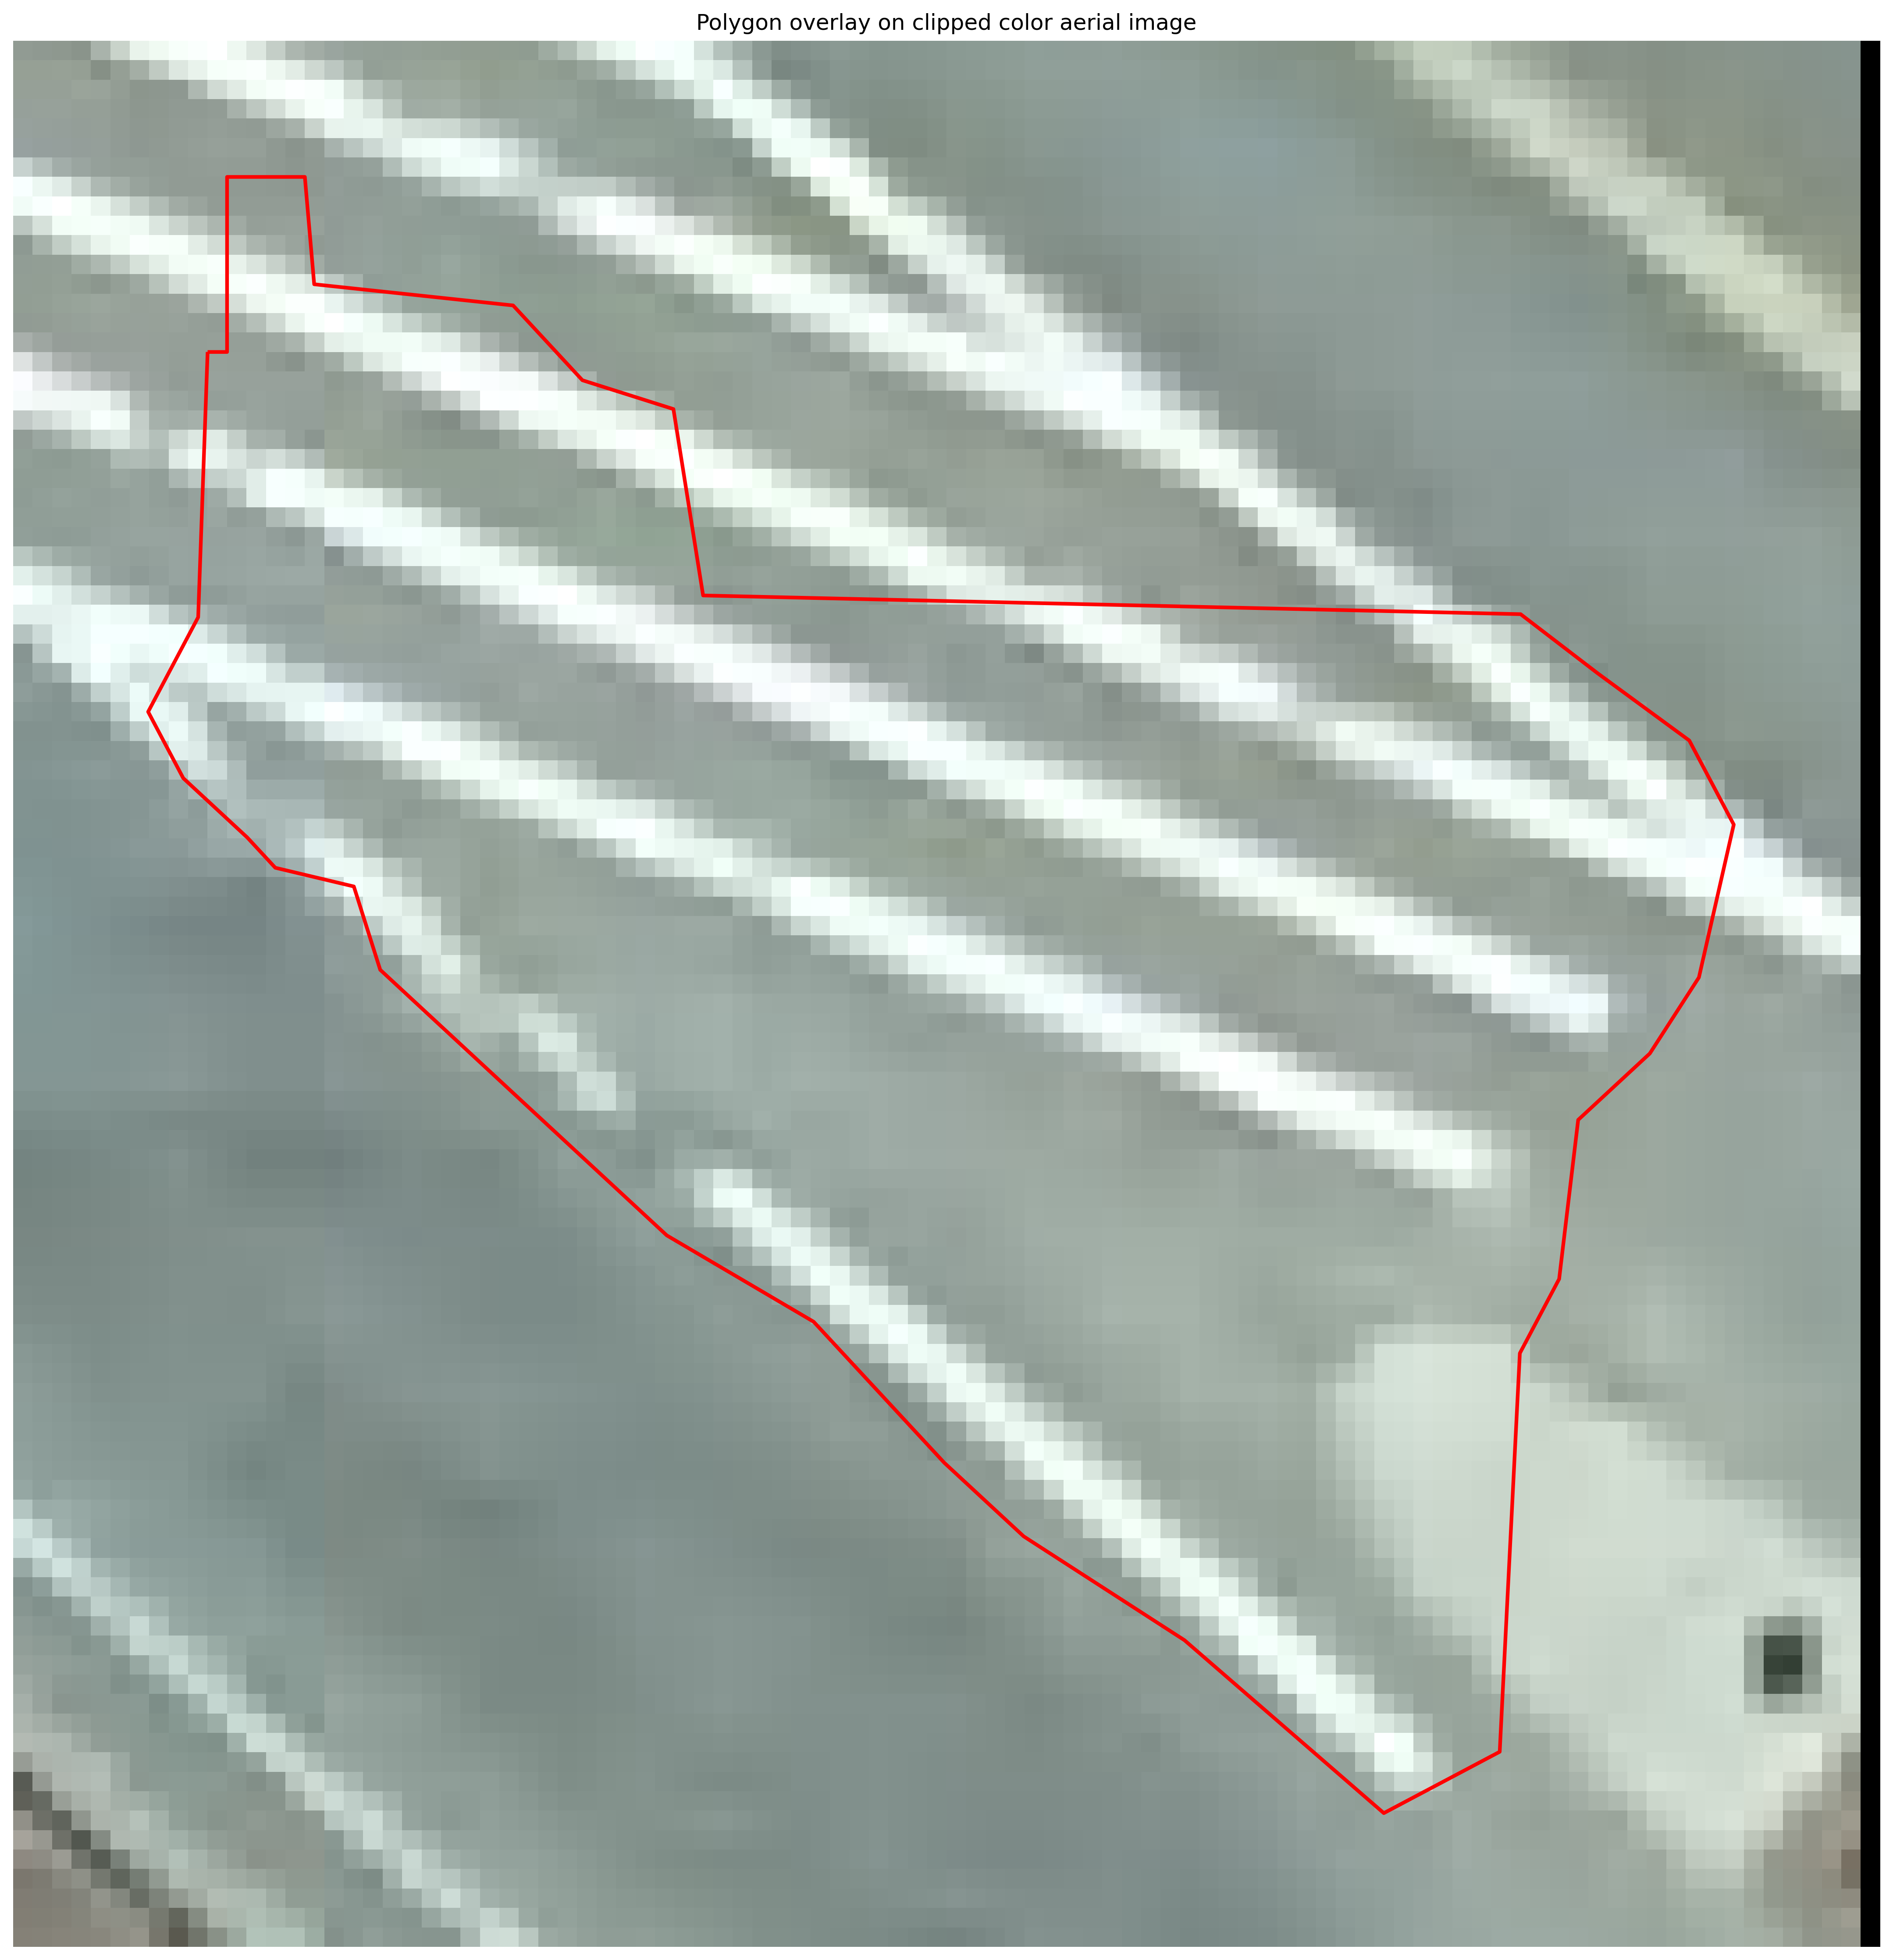

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2


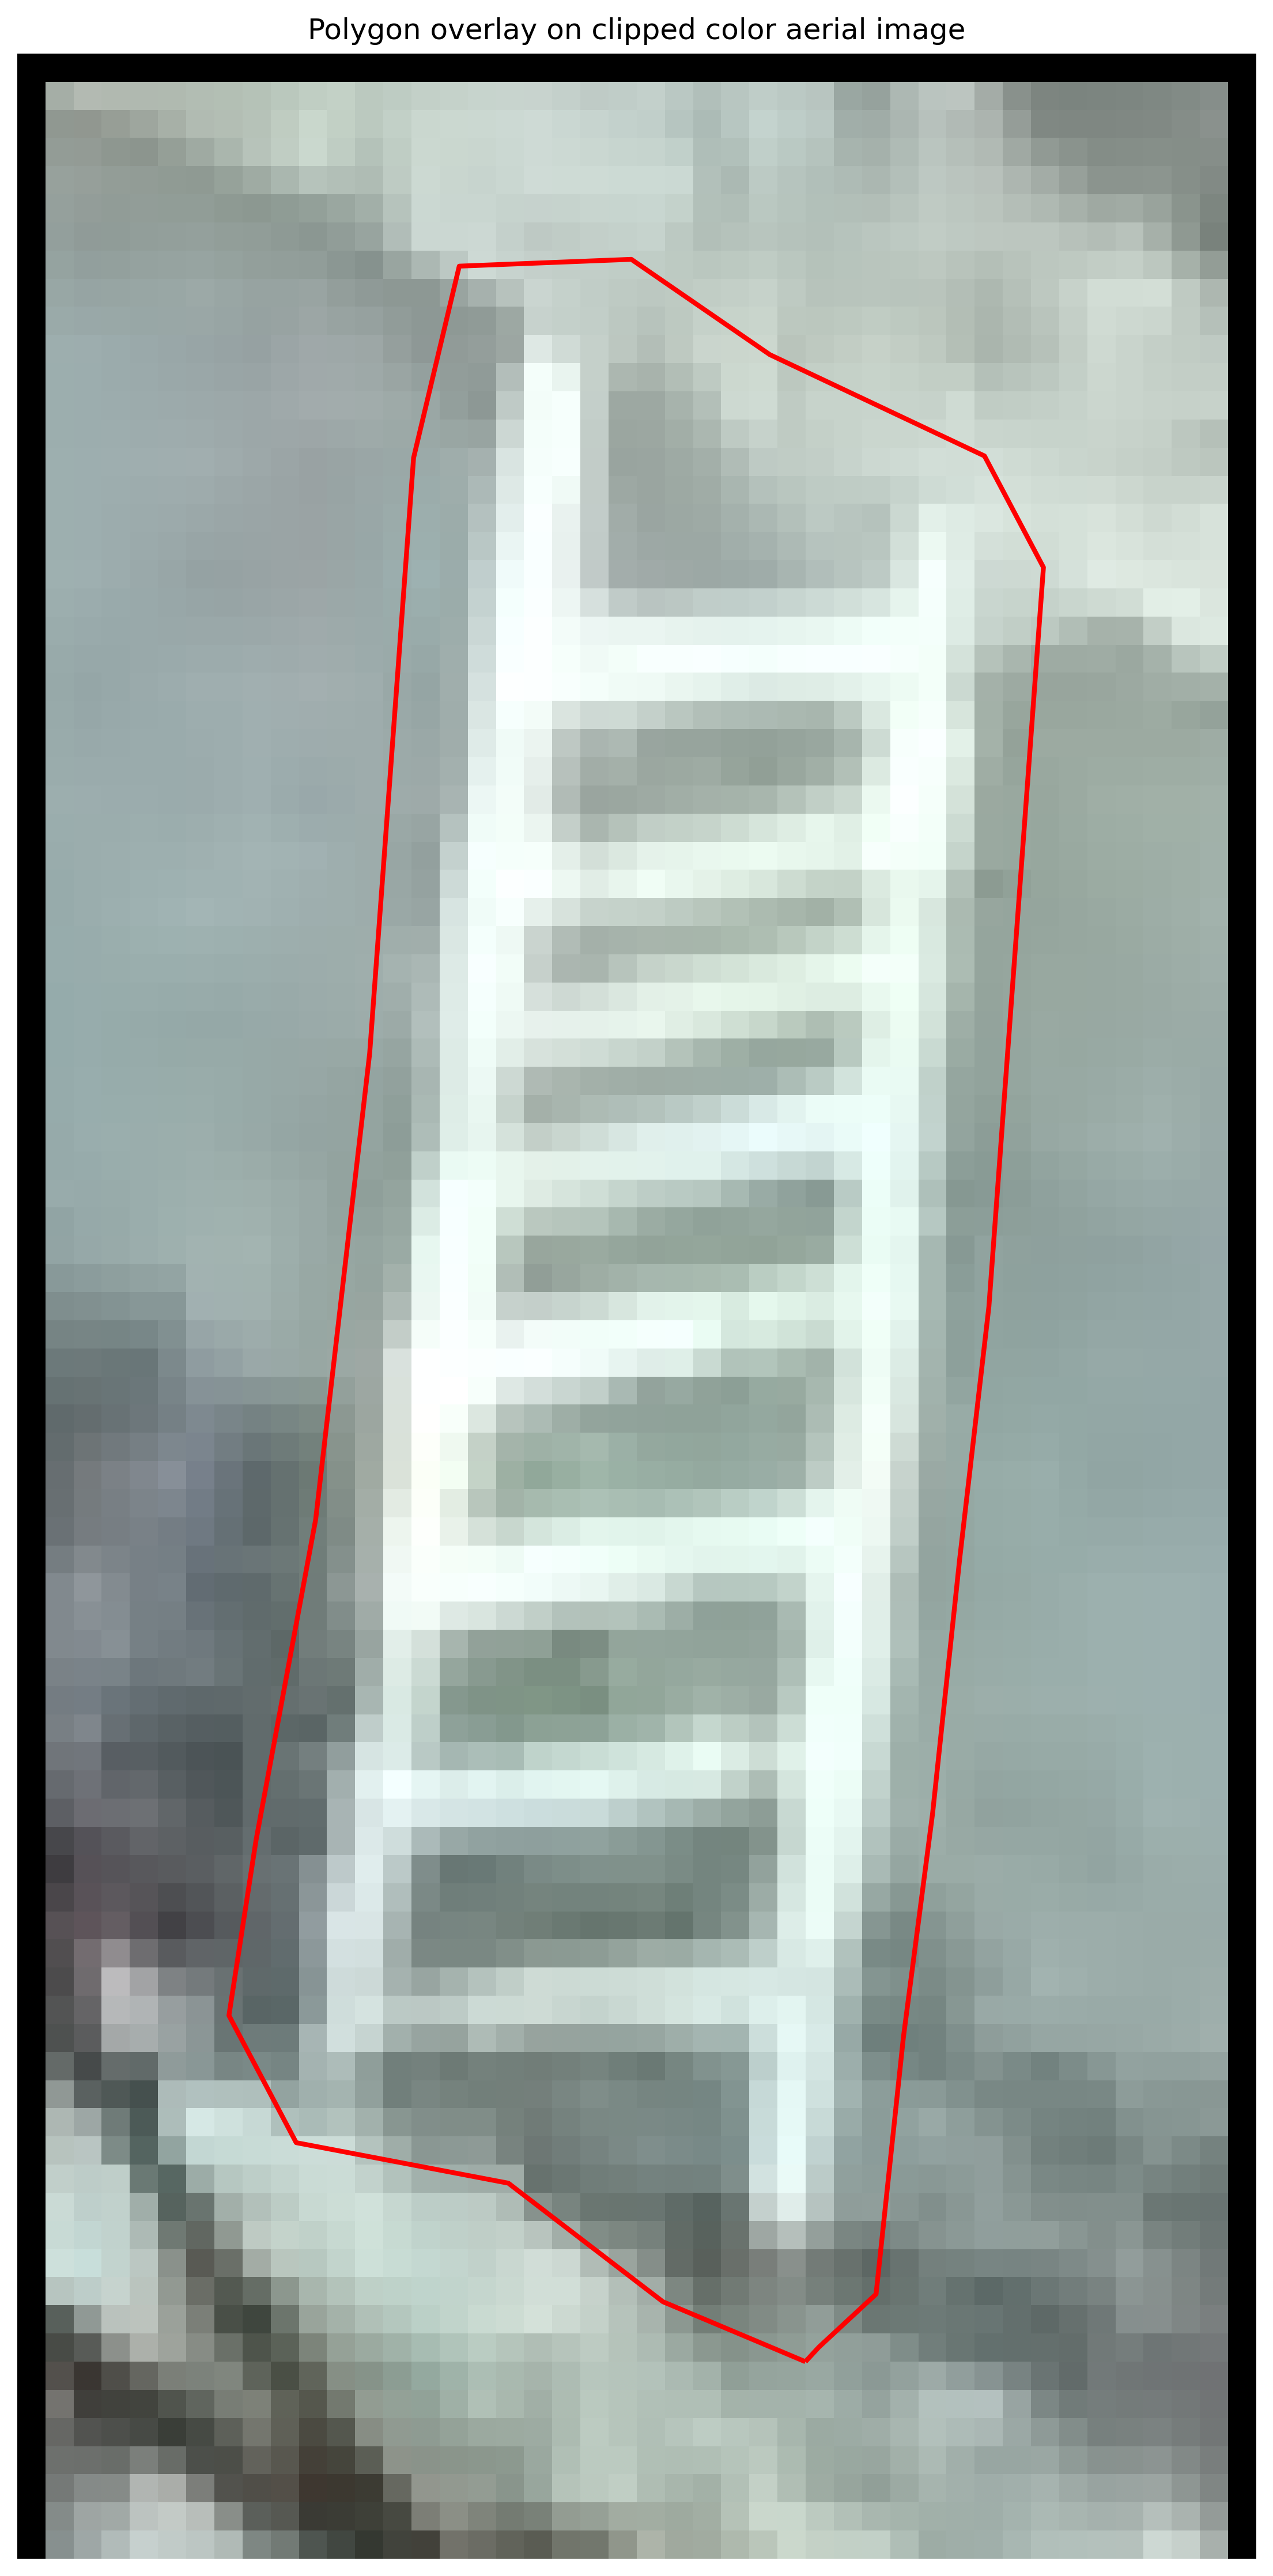

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2


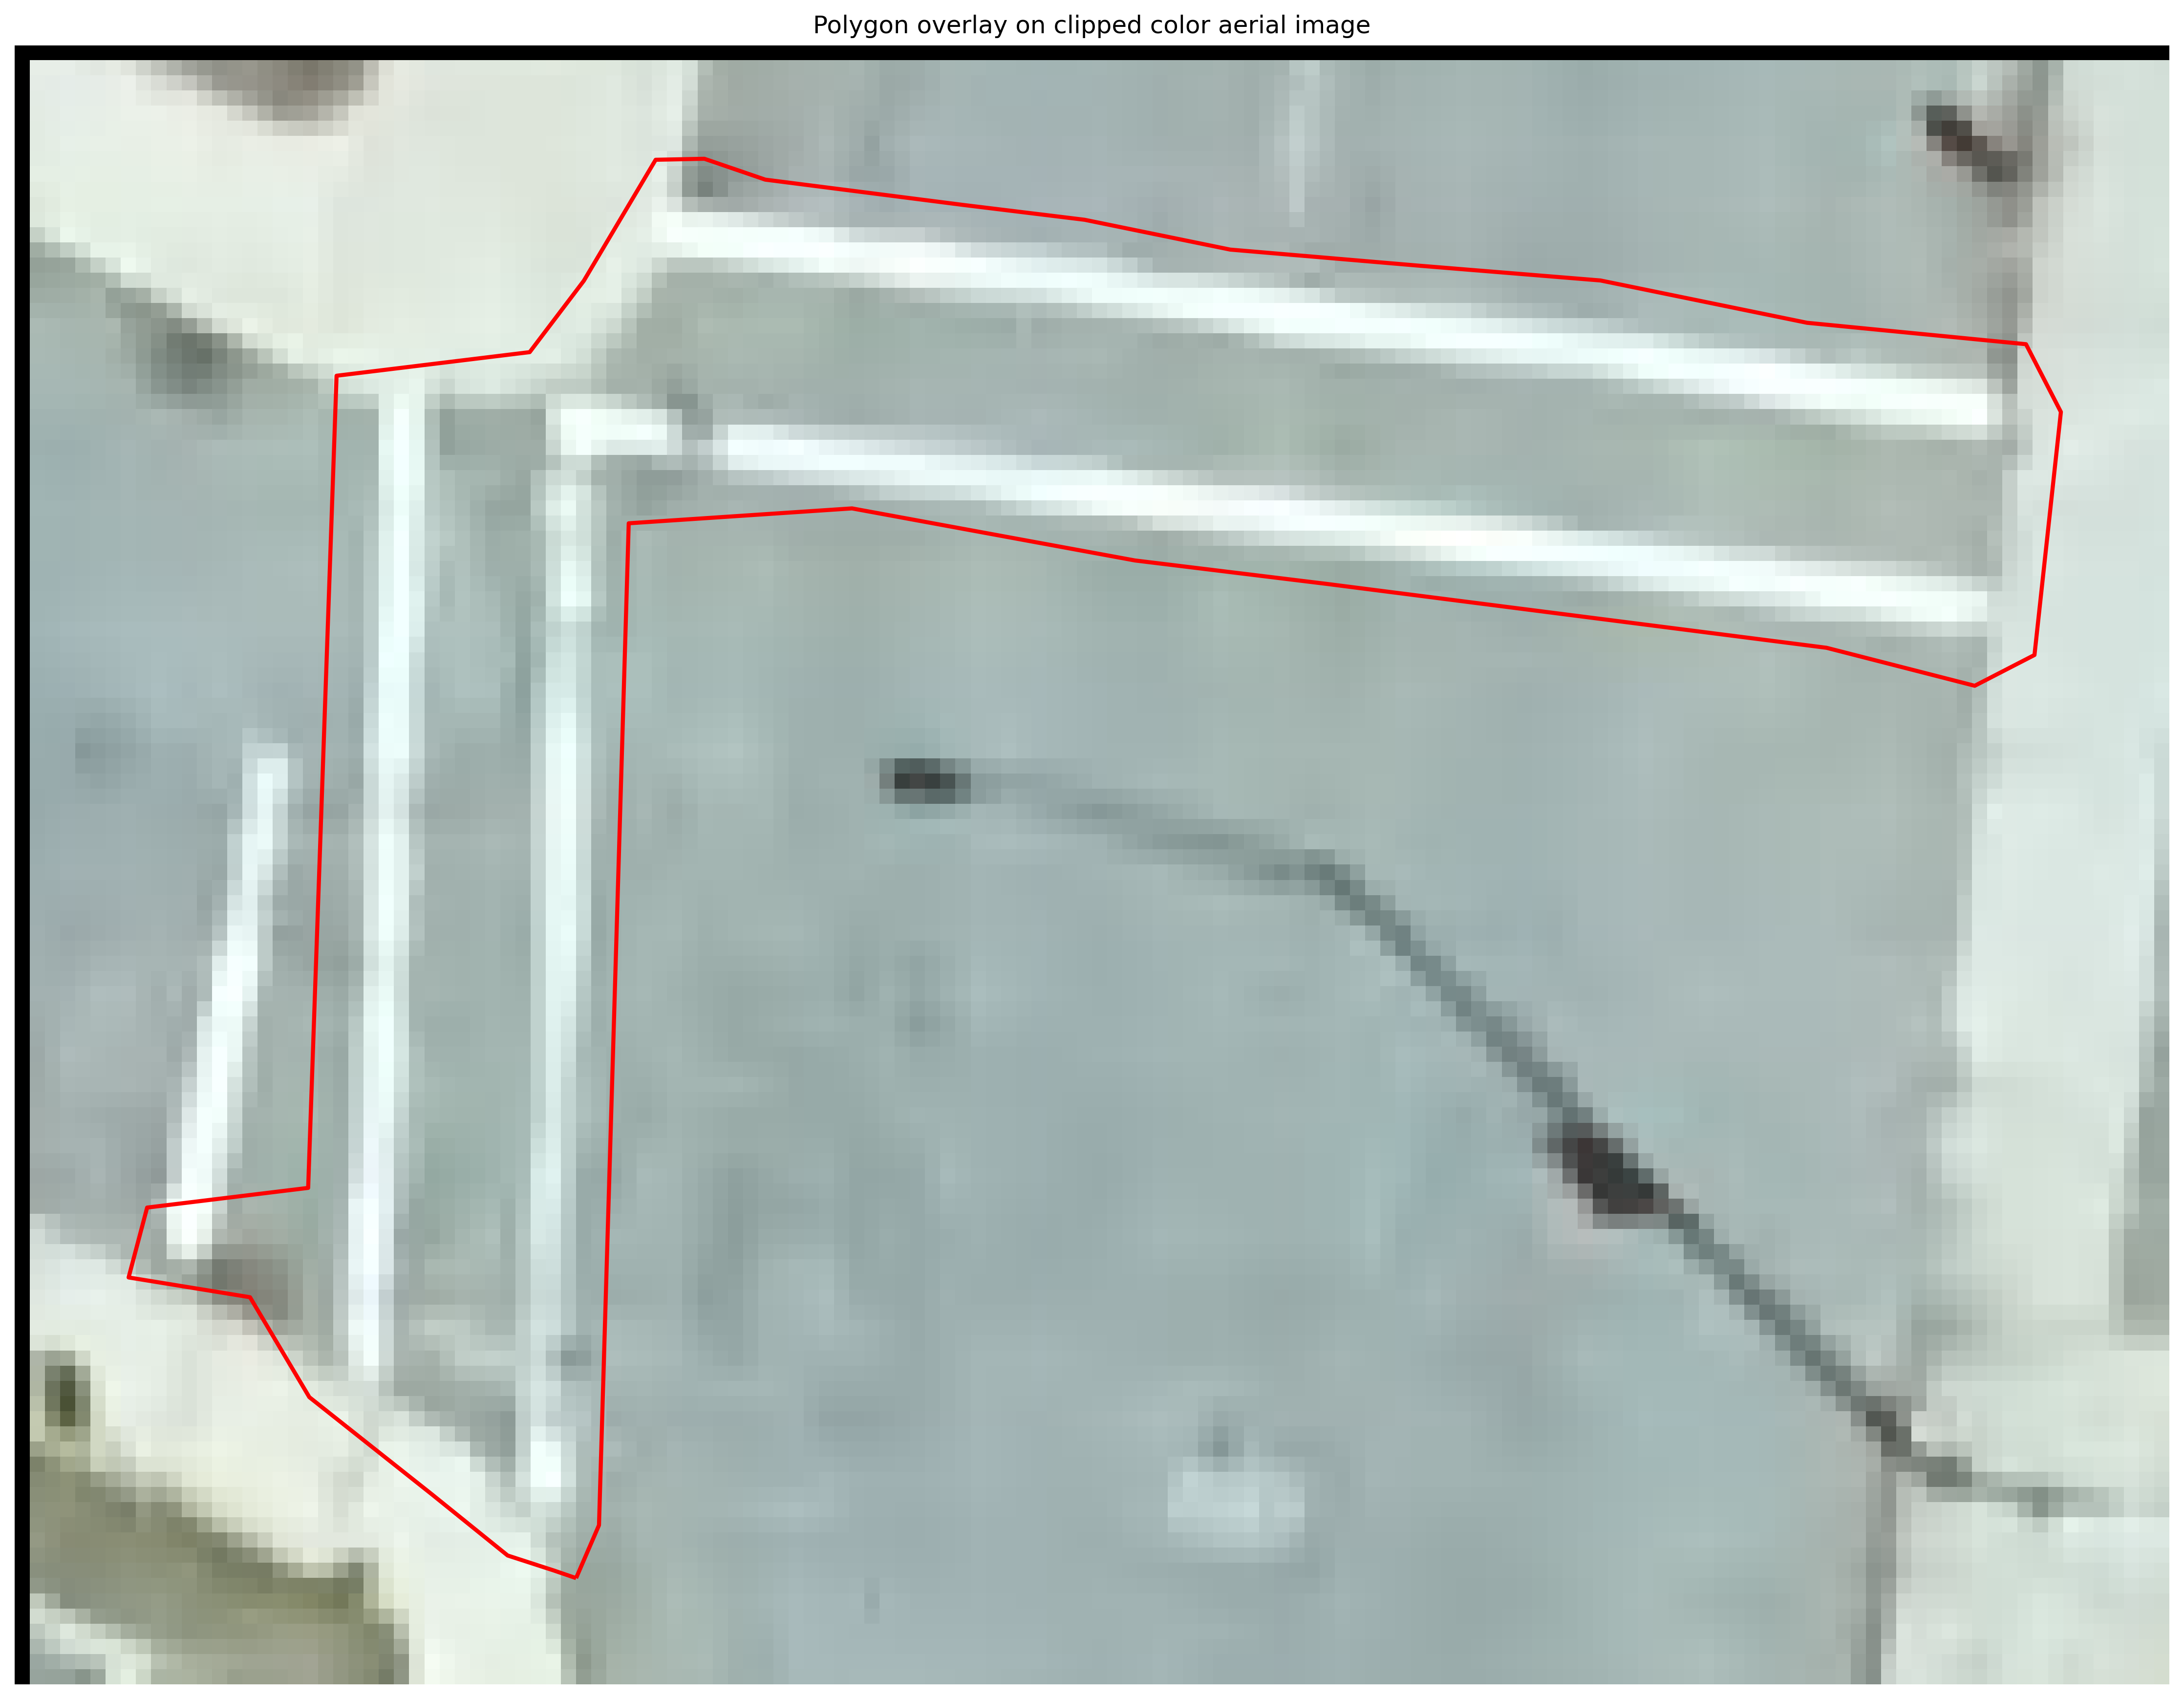

0:00:21.011586


In [253]:
start = time.time()
for i in range(3, 6):
    # visualize_intersection(res_gdf, i)
    superimpose_polygon_on_tile(polygon_mappings, i)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

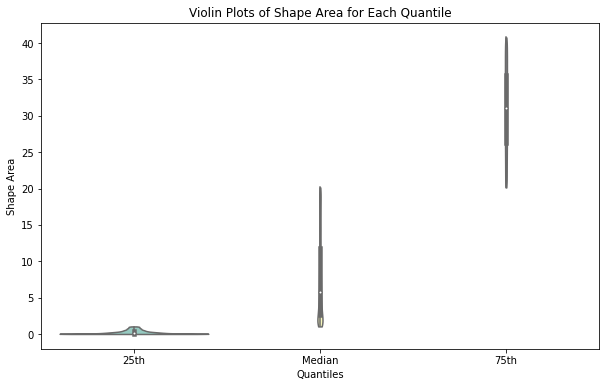

In [18]:
# Create violin plots with Brewer color set
plt.figure(figsize=(10, 6))
sns.violinplot(data=[combined_results['Shape_Area'][quantiles[0.25] > combined_results['Shape_Area']],
                     combined_results['Shape_Area'][(quantiles[0.25] <= combined_results['Shape_Area']) & (combined_results['Shape_Area'] <= quantiles[0.5])],
                     combined_results['Shape_Area'][(quantiles[0.5] < combined_results['Shape_Area']) & (combined_results['Shape_Area'] <= quantiles[0.75])]],
               palette='Set3', cut=0)
plt.xticks([0, 1, 2], ['25th', 'Median', '75th'])
plt.xlabel('Quantiles')
plt.ylabel('Shape Area')
plt.title('Violin Plots of Shape Area for Each Quantile')
plt.savefig("violin_plot_quantiles.jpg", dpi=300)
plt.show()

In [20]:
sample_tile['centroid'] = sample_tile['geometry'].centroid
bounding_box = sample_tile['centroid'].apply(lambda centroid: Point(centroid.x, centroid.y).buffer(1))
roads_transformed['geometry']

In [78]:
def visualize_simple_intersection(polygon_id=33956, road_id=314345, zoom_in=True):
    polygon = western_mass.iloc[polygon_id-1]['geometry']
    road_segment = roads_transformed.iloc[road_id-1]['geometry']
    buffered_polygon = polygon.buffer(1)
    bounding_box = buffered_polygon.bounds
    # Bounding box coordinates
    minx, miny, maxx, maxy = bounding_box
    # Create a Polygon from the bounding box coordinates
    bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
    print(bounding_polygon)
    # Convert objects to geodataframes (gdfs)
    polygon_gdf = gpd.GeoDataFrame(geometry=[polygon])
    bounding_polygon_gdf = gpd.GeoDataFrame(geometry=[bounding_polygon])
    road_segment_gdf = gpd.GeoDataFrame(geometry=[road_segment])
    # Calculate the intersection between the line segment and the bounding box
    intersection = bounding_polygon.intersection(road_segment)
    intersection_gdf = gpd.GeoDataFrame(geometry=[intersection])
    # Visualize the itnersection
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.axis('off')
    polygon_gdf.plot(ax=ax, color='red')
    bounding_polygon_gdf.boundary.plot(ax=ax, linewidth=1, color='green')
    if(zoom_in):
        intersection_gdf.plot(ax=ax)
    else:
        road_segment_gdf.plot(ax=ax)
    plt.savefig("intersection.jpg", dpi=300)
    plt.show()

POLYGON ((699898.9755664704 4664256.05005366, 699912.3360708214 4664256.05005366, 699912.3360708214 4664269.721154339, 699898.9755664704 4664269.721154339, 699898.9755664704 4664256.05005366))


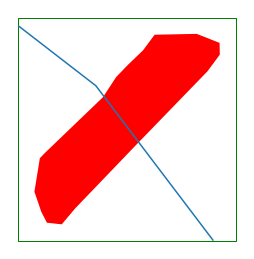

In [79]:
visualize_simple_intersection()

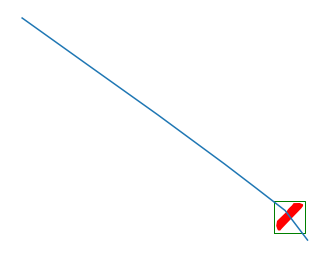

In [75]:
visualize_simple_intersection(zoom_in=False)

<AxesSubplot:>

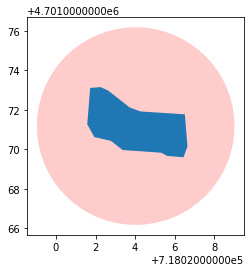

In [177]:
combined_results['centroid'] = combined_results['geometry'].centroid
bounding_box = combined_results['centroid'][:1].apply(lambda centroid: Point(centroid.x, centroid.y).buffer(5))
fig, ax = plt.subplots()
bounding_box.plot(ax=ax, color='red', alpha=0.2)
combined_results['geometry'][:1].plot(ax=ax)

In [72]:
# Normalize values
normalized_shape_area = (gdf_filtered['Shape_Area'] - gdf_filtered['Shape_Area'].mean()) / gdf_filtered['Shape_Area'].std()
# Insert normalized values next to 'Shape_Area'
gdf_filtered.insert(gdf_filtered.columns.get_loc('Shape_Area') + 1, 'Normalized_Shape_Area', normalized_shape_area)

In [74]:
gdf_filtered['Normalized_Shape_Area'].quantile([0.25, 0.5, 0.75])

0.25   -0.554044
0.50   -0.444458
0.75    0.352182
Name: Normalized_Shape_Area, dtype: float64

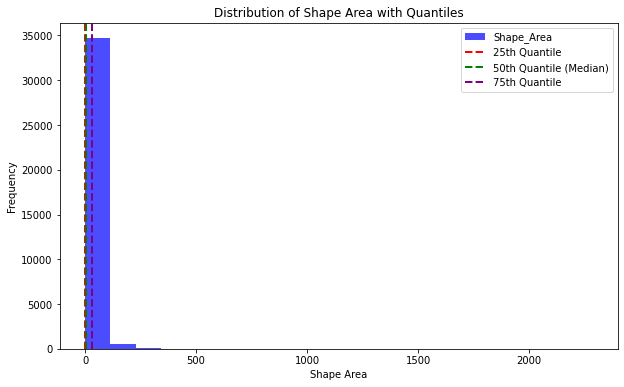

In [75]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(gdf_filtered['Shape_Area'], bins=20, alpha=0.7, color='blue', label='Shape_Area')
plt.axvline(x=quantiles[0.25], color='red', linestyle='dashed', linewidth=2, label='25th Quantile')
plt.axvline(x=quantiles[0.5], color='green', linestyle='dashed', linewidth=2, label='50th Quantile (Median)')
plt.axvline(x=quantiles[0.75], color='purple', linestyle='dashed', linewidth=2, label='75th Quantile')
plt.xlabel('Shape Area')
plt.ylabel('Frequency')
plt.title('Distribution of Shape Area with Quantiles')
plt.legend()
plt.savefig("distribution_shape_area.jpg", dpi=300)
plt.show()

In [49]:
len(normalized_values)

35271

In [51]:
normalized_values

0       -0.227441
1       -0.558385
2        0.052936
3       -0.188085
4       -0.526967
           ...   
35266   -0.348458
35267   -0.559924
35268   -0.562032
35269   -0.559883
35270   -0.559883
Name: Shape_Area, Length: 35271, dtype: float64

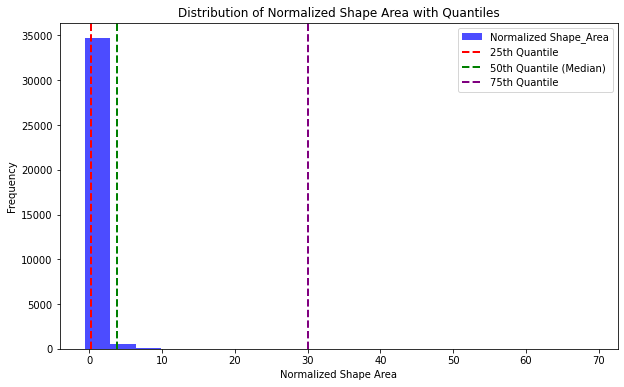

In [62]:
# Create a histogram with normalized values
plt.figure(figsize=(10, 6))
plt.hist(normalized_values, bins=20, alpha=0.7, color='blue', label='Normalized Shape_Area')
plt.axvline(x=quantiles[0.25], color='red', linestyle='dashed', linewidth=2, label='25th Quantile')
plt.axvline(x=quantiles[0.5], color='green', linestyle='dashed', linewidth=2, label='50th Quantile (Median)')
plt.axvline(x=quantiles[0.75], color='purple', linestyle='dashed', linewidth=2, label='75th Quantile')
plt.xlabel('Normalized Shape Area')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized Shape Area with Quantiles')
plt.legend()
plt.savefig("distribution_normalized_shape.jpg", dpi=300)
plt.show()

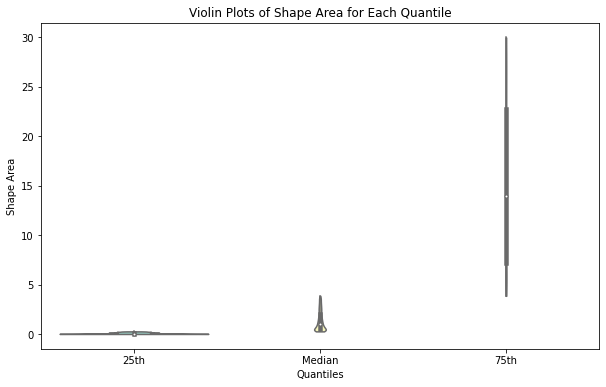

In [81]:
# Create violin plots with Brewer color set
plt.figure(figsize=(10, 6))
sns.violinplot(data=[gdf_filtered['Shape_Area'][quantiles[0.25] > gdf_filtered['Shape_Area']],
                     gdf_filtered['Shape_Area'][(quantiles[0.25] <= gdf_filtered['Shape_Area']) & (gdf_filtered['Shape_Area'] <= quantiles[0.5])],
                     gdf_filtered['Shape_Area'][(quantiles[0.5] < gdf_filtered['Shape_Area']) & (gdf_filtered['Shape_Area'] <= quantiles[0.75])]],
               palette='Set3', cut=0)
plt.xticks([0, 1, 2], ['25th', 'Median', '75th'])
plt.xlabel('Quantiles')
plt.ylabel('Shape Area')
plt.title('Violin Plots of Shape Area for Each Quantile')
plt.savefig("violin_plot_quantiles.jpg", dpi=300)
plt.show()